# 記述子クラスの実装

`cheminfo/descriptors.py`に保存した記述子計算クラスを
使って、SMILESから記述子計算をする。

PLSによる回帰分析で予測性の高い記述子計算を選定する

In [1]:
%load_ext autoreload
%autoreload 2 

from rdkit import Chem
from rdkit.Chem.AllChem import GetHashedMorganFingerprint
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

RDKit WARNING: [18:16:04] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
df=pd.read_csv('../data/delaney-solubility/delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

## ハッシュ化されたMorganフィンガープリントの例

In [3]:
toluene = Chem.MolFromSmiles('Cc1ccccc1')
hmfp = GetHashedMorganFingerprint(mol=toluene, radius=3, nBits=512)
hmfp.GetNonzeroElements()

{31: 2,
 33: 1,
 64: 3,
 175: 2,
 186: 1,
 214: 2,
 287: 1,
 309: 1,
 337: 5,
 356: 1,
 384: 1,
 389: 1,
 411: 1}

## ハッシュ化されたMorganフィンガープリントを出力するクラス

In [4]:
import sys 
sys.path.append('../')# ノートブック上にライブラリを呼ぶ
from cheminfo.descriptors import HashedMorgan, RDKitDescriptor

hm = HashedMorgan()
X = hm.fit_transform(df['mol'])

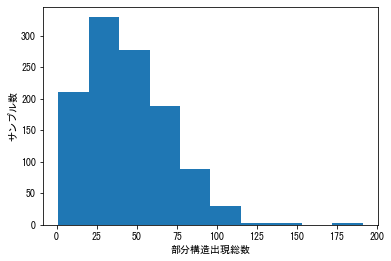

In [5]:
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'MS Gothic'
mpl.rcParams['font.size'] = 25
import matplotlib.pyplot as plt 
plt.hist(X.sum(axis=1))
plt.xlabel('部分構造出現総数')
plt.ylabel('サンプル数')
plt.show()

## PLSと最適な記述子

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_decomposition import PLSRegression

In [7]:
df_train, df_test = train_test_split(df, 
                                     test_size=.20, 
                                     random_state=42)

In [8]:
TARGET=['measured log solubility in mols per litre']

In [9]:
ytrain = df_train[TARGET]
params={'n_components': np.arange(1,16)}
scores = np.zeros((18,3))
count = 0
for radius in range(1, 4):
    for n_bits in 2**np.arange(5, 11):
        model = GridSearchCV(PLSRegression(), params, cv=5)
        Xtrain = HashedMorgan(n_bits, radius).fit_transform(df_train['mol'])
        model.fit(Xtrain, ytrain)
        score_cv = model.best_score_
        scores[count,:] = np.array([radius, n_bits, score_cv])
        count+=1 

In [10]:
mpl.rcParams['figure.figsize'] = [12, 8]

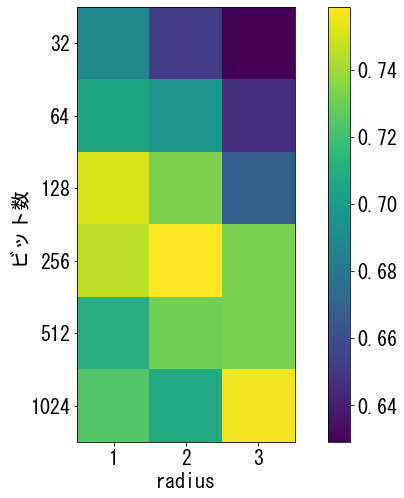

In [11]:
mpl.rcParams['font.size'] = 20
fig,ax=plt.subplots()
im = ax.imshow(scores[:,-1].reshape(3,6).T)
fig.colorbar(im)
ax.set_xticks(range(3))
ax.set_yticks(range(6))
ax.set_xticklabels(range(1,4))
ax.set_yticklabels(map(int,scores[:,1]))
plt.xlabel('radius')
plt.ylabel('ビット数')
# plt.savefig('../results/10.3-optim-hashedmorgan-pls.jpg')
plt.show()

### 最良のパラメータを確認

In [12]:
ix=scores[:,-1].argmax()
print('radius: {}, n_bits: {} R^2:{:.3f}'.format(*scores[ix,:]))

radius: 2.0, n_bits: 256.0 R^2:0.759


## PLSとRDKit記述子の場合

calc: 0.914
cv: 0.876
pred: 0.878


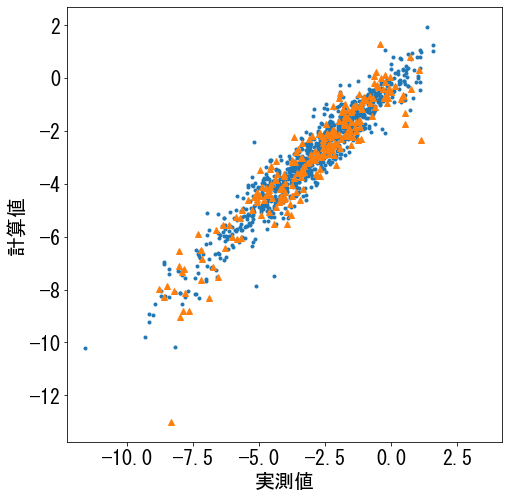

In [14]:
from sklearn import metrics
rdcalc = RDKitDescriptor()
Xtrain = rdcalc.fit_transform(df_train['mol'])
Xtest = rdcalc.transform(df_test['mol'])
ytest = df_test[TARGET]

params = {'n_components':np.arange(1, 16)}
optim = GridSearchCV(PLSRegression(), params)
optim.fit(Xtrain, ytrain)
ycalc = optim.predict(Xtrain)
ypred = optim.predict(Xtest)
print('calc: %.3f'%metrics.r2_score(ytrain,ycalc))
print('cv: %.3f'%optim.best_score_)
print('pred: %.3f'%metrics.r2_score(ytest,ypred))

plt.plot(ytrain, ycalc, '.')
plt.plot(ytest, ypred, '^')
plt.plot()
plt.axis('square')
plt.xlabel('実測値')
plt.ylabel('計算値')
plt.savefig('../results/9.3-yyplot-rdkitpls.jpg')
plt.show()

### 交差検定の結果、良好な精度だったので利用する（モデル保存）

In [15]:
from joblib import dump
dump(optim, '../models/9.3_rdkit_pls.joblib')

['../models/9.3_rdkit_pls.joblib']

In [16]:
from cheminfo.metrics import t2_score, q_value 

In [17]:
print('#training samples', Xtrain.shape)

#training samples (902, 200)


In [18]:
t2_values = t2_score(np.array(Xtrain), optim)
q_values = q_value(np.array(Xtrain), optim)
t2_95q = np.quantile(t2_values, 0.95)
qval_95q = np.quantile(q_values, 0.95)
print('t^2 - 95% quantile', t2_95q, '\nq value - 95% quantile', qval_95q)

t^2 - 95% quantile 32.344471901471536 
q value - 95% quantile 2.7282295570655064e+21


In [19]:
count = 0 
with open('../results/mol_quad.out', 'r') as f:
    for line in f:
        line = line.strip()
        info = line.split()
        if np.float(info[2])<=t2_95q and np.float(info[3])<=qval_95q:
            count += 1
    else:
        print('予測結果の信頼できる化合物の数', count)

予測結果の信頼できる化合物の数 43535


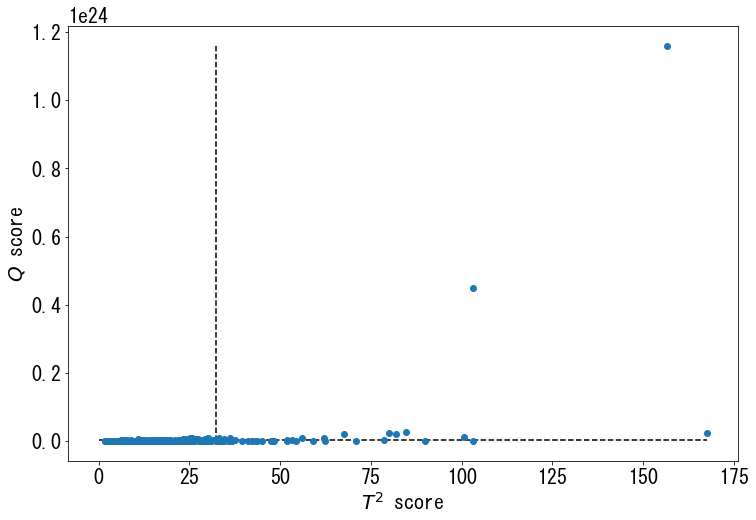

In [20]:
plt.plot(t2_values, q_values, 'o')
plt.xlabel('$T^2$ score')
plt.ylabel('$Q$ score')
plt.vlines(t2_95q, ymin=0, ymax=q_values.max(), linestyles='--')
plt.hlines(qval_95q, xmin=0, xmax=t2_values.max(), linestyles='--')
plt.show()